In [1]:
import os.path
import sys
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
import scoping
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

## Load the labelled data

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

(2223, 242)


## The relevant value is evenly distributed

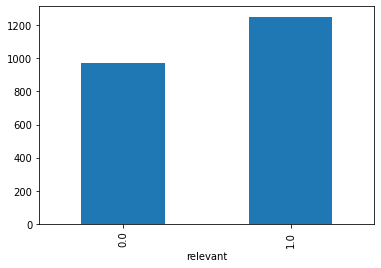

In [3]:
seen_df.groupby('relevant').size().plot.bar()

In [4]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=15, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2223, 6519)

In [5]:
test_X = vec.transform(df.loc[df['id']==38721,'content']).todense()
idx = np.ravel(np.argsort(test_X))[-15:]
test_X[:,idx]

matrix([[0.11049948, 0.11159761, 0.11354381, 0.12872105, 0.1365881 ,
         0.14249295, 0.14660467, 0.14949199, 0.15508891, 0.17445467,
         0.19576018, 0.20491832, 0.21353895, 0.23593399, 0.27072755]])

In [6]:
vocab = np.array(vec.get_feature_names())
vocab[idx]

array(['led to', 'in spring', 'continued', 'phases', 'requirements',
       'winter', 'advancing', 'in winter', 'growing season', 'growing',
       'phenology', 'vegetation', 'delay', 'the growing', 'spring'],
      dtype='<U32')

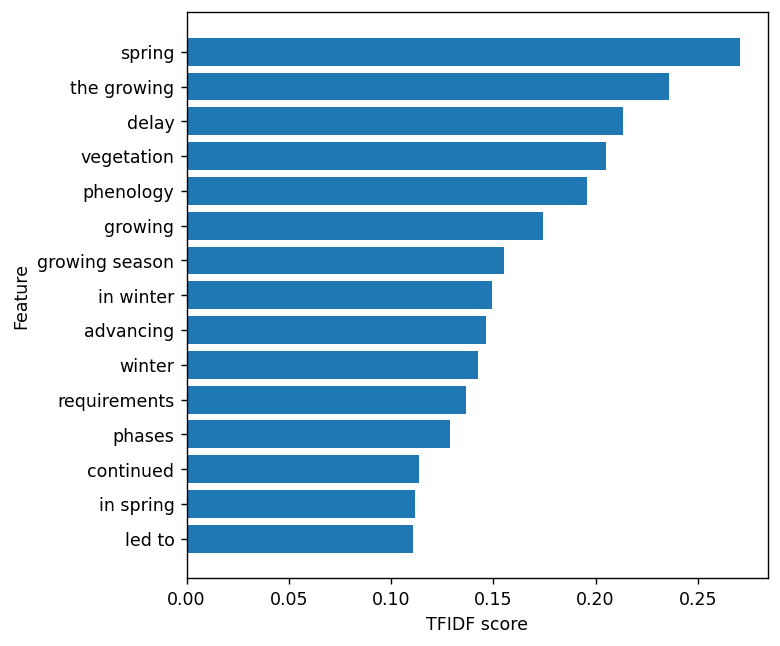

In [7]:
fig, ax = plt.subplots(dpi=125, figsize=(6,6))
bar_idx =np.arange(idx.size)
ax.barh(bar_idx, np.ravel(test_X[:,idx]))
ax.set_yticks(bar_idx)
ax.set_yticklabels(vocab[idx])

ax.set_ylabel('Feature')
ax.set_xlabel('TFIDF score')

plt.savefig('../presentation/images/example_doc_tfidf.pdf', bbox_inches="tight")

In [8]:
test_X

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [9]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


y = df['relevant']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True)
    },
    {
        'title': "GB",
        'model': GradientBoostingClassifier(random_state=0)
    },
    {
        'title': "GB",
        'model': GradientBoostingClassifier(random_state=0, n_estimators=500)
    },
    {
        'title': "Adaboost",
        'model': AdaBoostClassifier()
    }
]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=6, df = df)

1
2
3
4
5
6


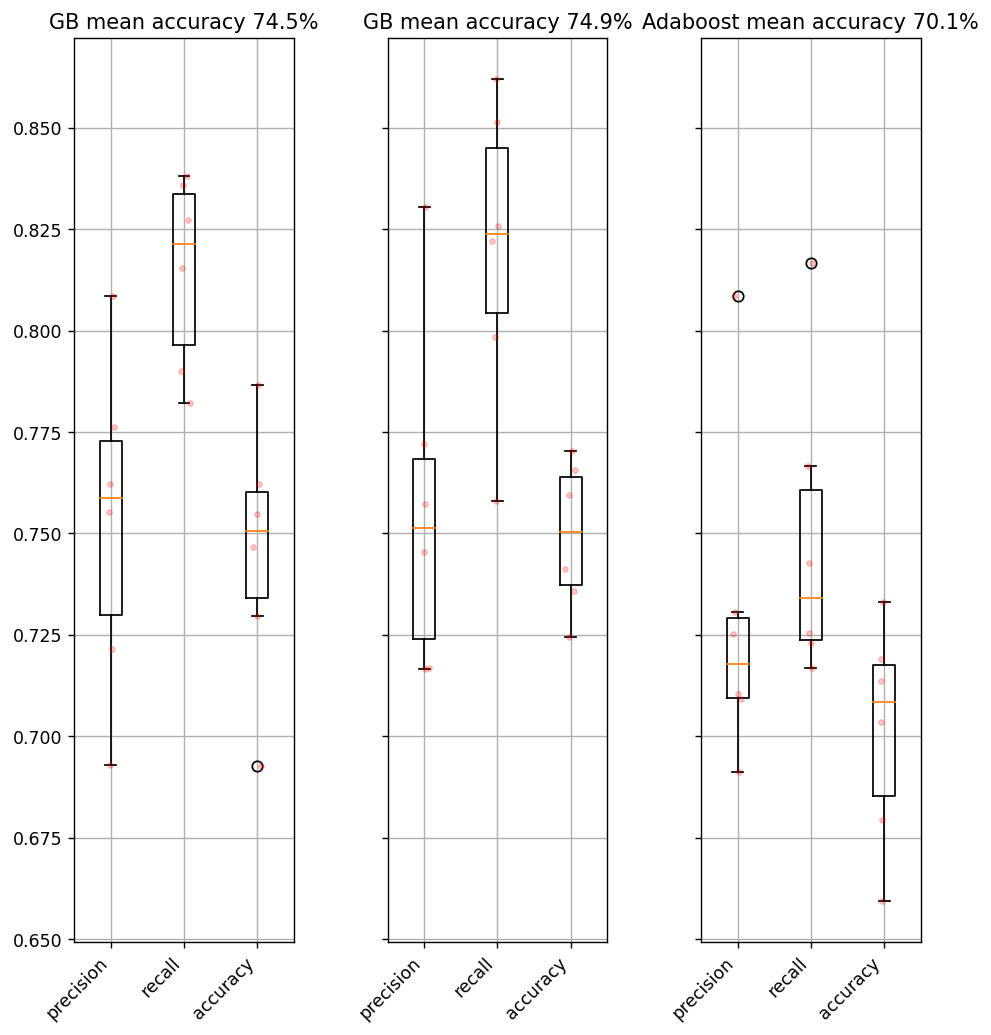

In [10]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models[2:]),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models[2:],  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

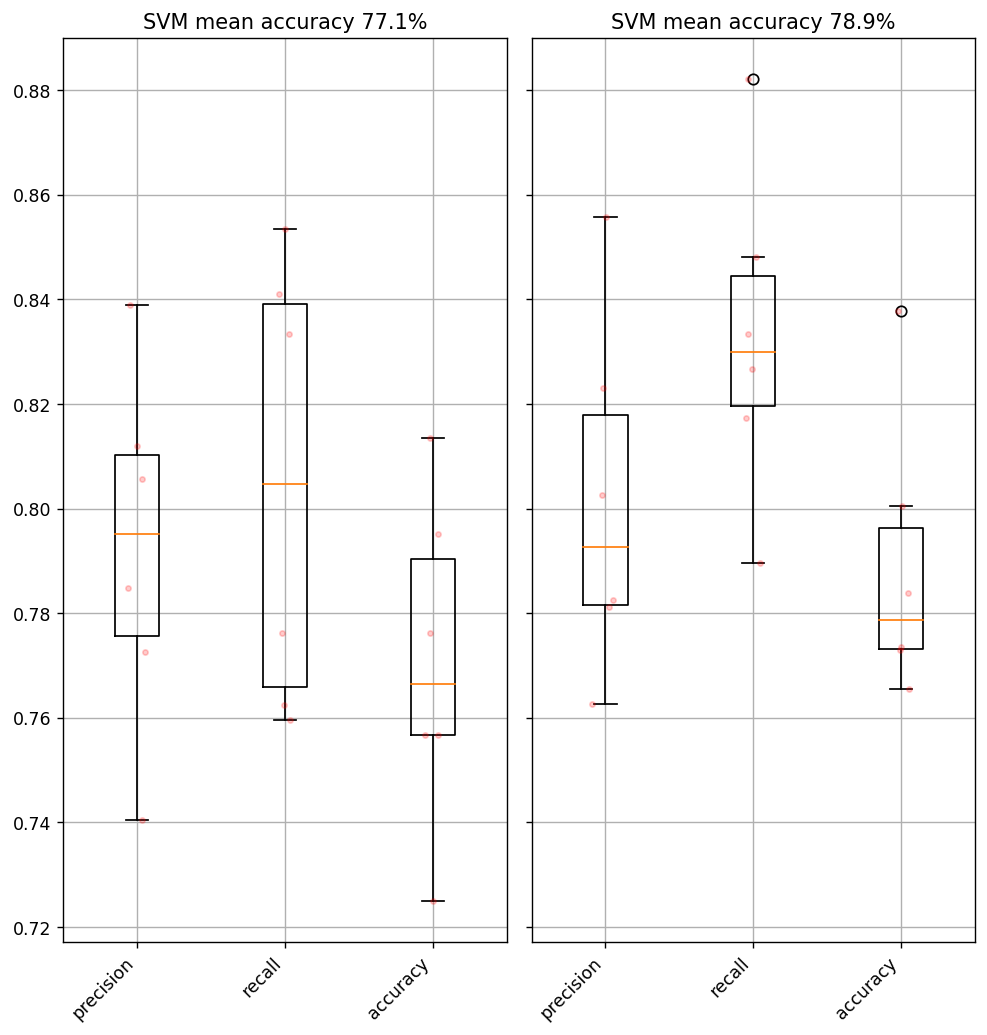

In [11]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models[:2]),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models[:2],  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

In [12]:
for model in clf_models:
    print(model["title"], model["auc"], np.mean(model["auc"]))

SVM [0.7214248052024137, 0.793368237347295, 0.7675983436853002, 0.7557407349393817, 0.811941391941392, 0.7523662644773049] 0.7670732962655147
SVM [0.7595201827875094, 0.7990837696335079, 0.7644927536231885, 0.7817110992763383, 0.8353113553113553, 0.7629804348483474] 0.7838499325800412
GB [0.6839885171949147, 0.7441681210005817, 0.7420289855072464, 0.7434917452460763, 0.7836630036630037, 0.7161692219299041] 0.7355849324236212
GB [0.7245591423047629, 0.7387725421756836, 0.7508281573498965, 0.7604554995144263, 0.7556776556776557, 0.7167437781608152] 0.7411727958638733
Adaboost [0.6730622766418654, 0.7305991855730075, 0.6938923395445136, 0.7166755427461546, 0.712967032967033, 0.6465269587831504] 0.6956205560426207


In [13]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=10, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2312, 7450)

In [14]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


y = df['relevant']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM lin 1', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True, C=1)
    },
    {
        'title': 'SVM rbf 10', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
    },
    {
        'title': 'SVM rbf 1', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=1)
    },

]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=10, df = df)

1
2
3
4
5
6
7
8
9
10


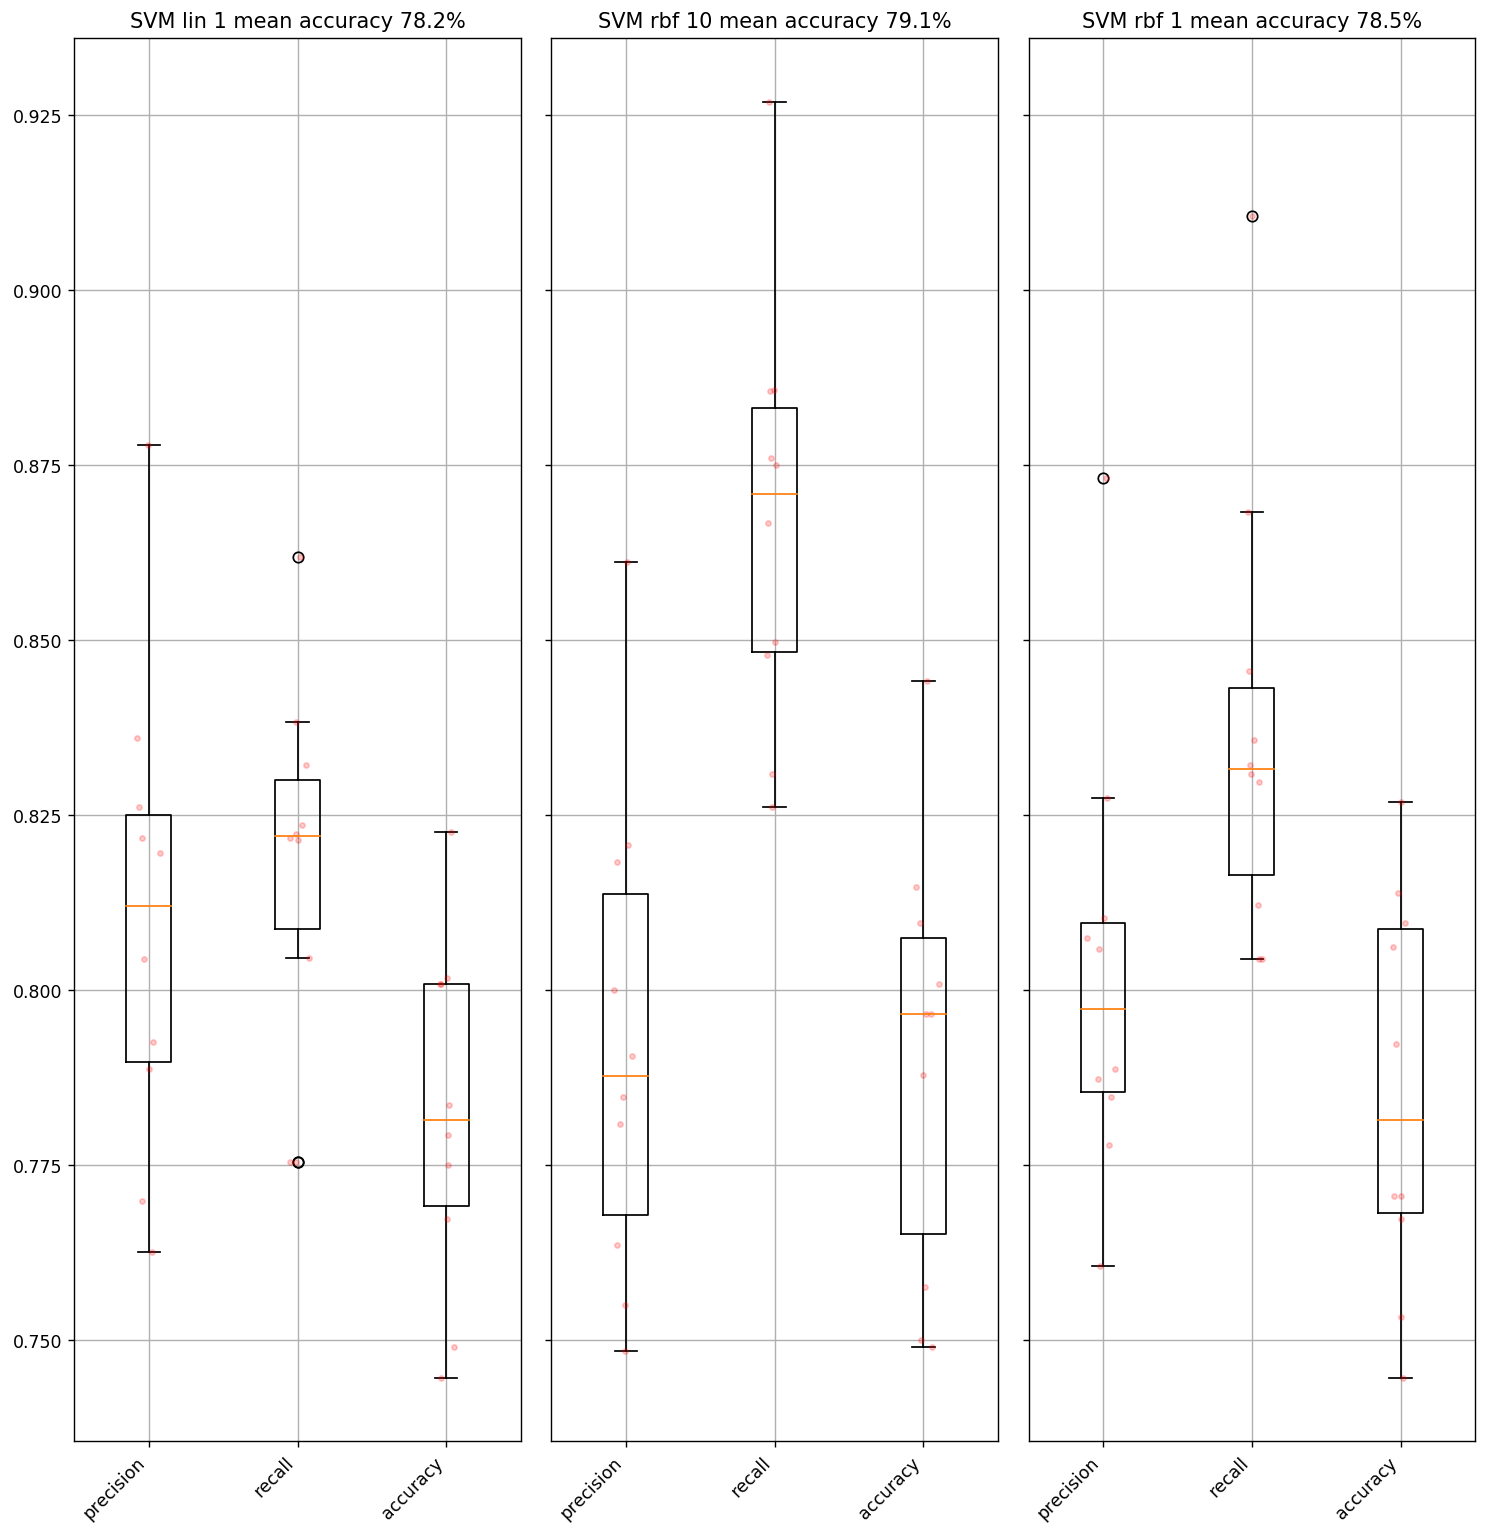

In [15]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(12,12),sharey=True)              
lu.plot_model_output(clf_models,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

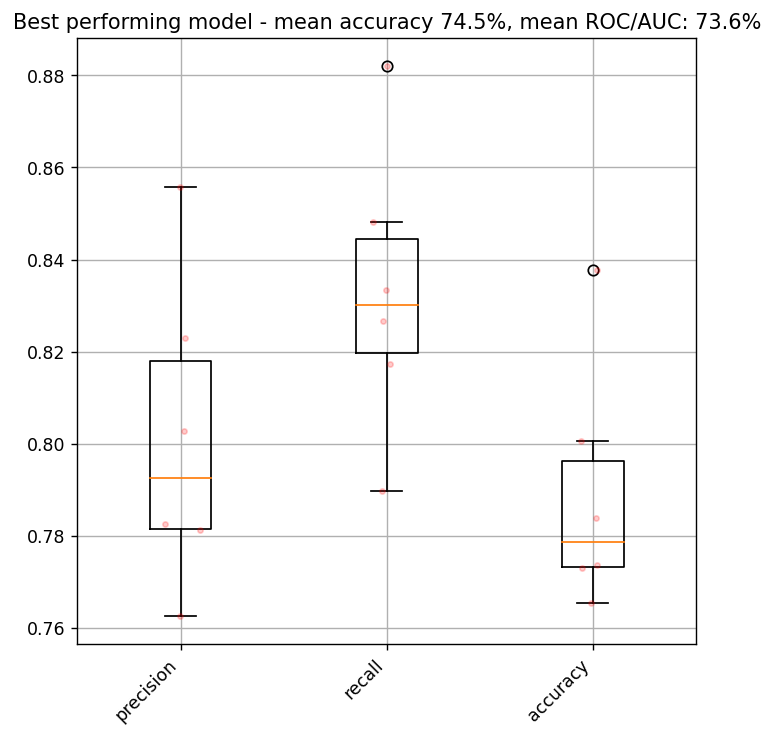

In [14]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, 1,dpi=125,figsize=(6,6),sharey=True)              
lu.plot_model_output([clf_models[1]],  ['p','r','e'], fig, [axs])
axs.set_xticklabels(["precision","recall","accuracy"])
    
f1 = np.mean(clf_models[2]['e'])
ma = np.mean(clf_models[2]['e'])
mauc = np.mean(clf_models[2]['auc'])
axs.set_title(f"Best performing model - mean accuracy {ma:.1%}, mean ROC/AUC: {mauc:.1%}")
fig.tight_layout()
plt.savefig(f'../plots/prediction_models/0_relevance_best_performing.pdf',bbox_inches="tight")
plt.show()

In [17]:
clf_models[2]['tpr']

[array([0.        , 0.78217822, 1.        ]),
 array([0.        , 0.82722513, 1.        ]),
 array([0.        , 0.83809524, 1.        ]),
 array([0.        , 0.81545064, 1.        ]),
 array([0.        , 0.83589744, 1.        ]),
 array([0.        , 0.78995434, 1.        ])]

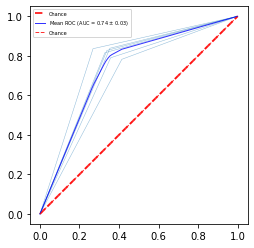

In [26]:
from sklearn.metrics import plot_roc_curve, auc
from scipy import interp
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

model = clf_models[2]

mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(model[f'auc'])
std_auc = np.std(model[f'auc'])
tprs = []
for i in range(len(model['i'])):
    viz = ax.plot(
        model[f'fpr'][i],
        model[f'tpr'][i],
        lw=0.5,
        alpha=0.5,
        color=f"C0"
    )

    interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(mean_fpr, mean_tpr, color='b',
label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
lw=1, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
    label='Chance', alpha=.8)

ax.legend(fontsize=5)
ax.set_aspect("equal")

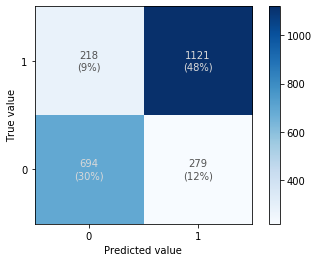

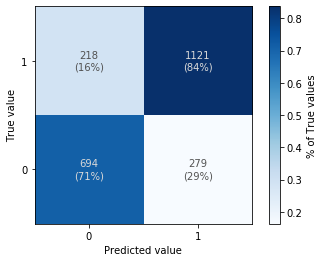

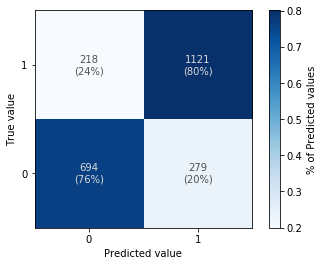

In [17]:
from sklearn.metrics import confusion_matrix
y_pred = [round(x) for x in df.loc[seen_index,'y_k_prediction']]
y_pred_prob = df.loc[seen_index,'y_k_prediction']
y_true = df.loc[seen_index,'relevant']


cm = confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm,norm=None,allprop=False):
    fig, ax = plt.subplots()
    
    cm = cm.T
    
    if norm is not None:
        if norm==1:
            ncm = cm/cm.sum(axis=norm)[:,None]
        else:
            ncm = cm/cm.sum(axis=norm)
    else:
        ncm = cm

    mat = ax.imshow(ncm, cmap="Blues",origin="lower")    

    for j, c in enumerate([0,1]):
        for k, c in enumerate([0,1]):
            n  = cm[j,k]
            if n > cm.mean():
                color="#d9d9d9"
            else:
                color="#525252"
            if norm is not None:
                ax.text(j,k, f"{cm[j,k]}\n({ncm[j,k]:.0%})",ha="center",color=color,va="center")
                #ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color, va="center")
            elif allprop:
                ax.text(j,k, f"{cm[j,k]}\n({cm[j,k]/cm.sum():.0%})",ha="center",color=color,va="center")
            else:
                ax.text(j,k, f"{cm[j,k]}",ha="center",color=color, va="center")

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    ax.set_ylabel("True value")
    ax.set_xlabel("Predicted value")
    
    cbar = fig.colorbar(mat, ax=ax)
    
    if norm is not None:
        cbar.set_label(f'% of {["True","Predicted",][norm]} values')
    
plot_confusion_matrix(cm,allprop=True)

plt.savefig(f'../plots/prediction_models/relevance_confusion.pdf',bbox_inches="tight")
                       
plot_confusion_matrix(cm,norm=0)

plt.savefig(f'../plots/prediction_models/relevance_confusion_recall.pdf',bbox_inches="tight")
                       
plot_confusion_matrix(cm,norm=1)

plt.savefig(f'../plots/prediction_models/relevance_confusion_precision.pdf',bbox_inches="tight")
#cbar.set_label("% of True values")

In [22]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


y = df['relevant']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True, C=10)
    },

]

clf_models, df = lu.cross_validate_models(
    X, y, clf_models, seen_index.difference(r_index), n_splits=10, df = df, test_index=r_index
)

1
2
3
4
5
6
7
8
9
10


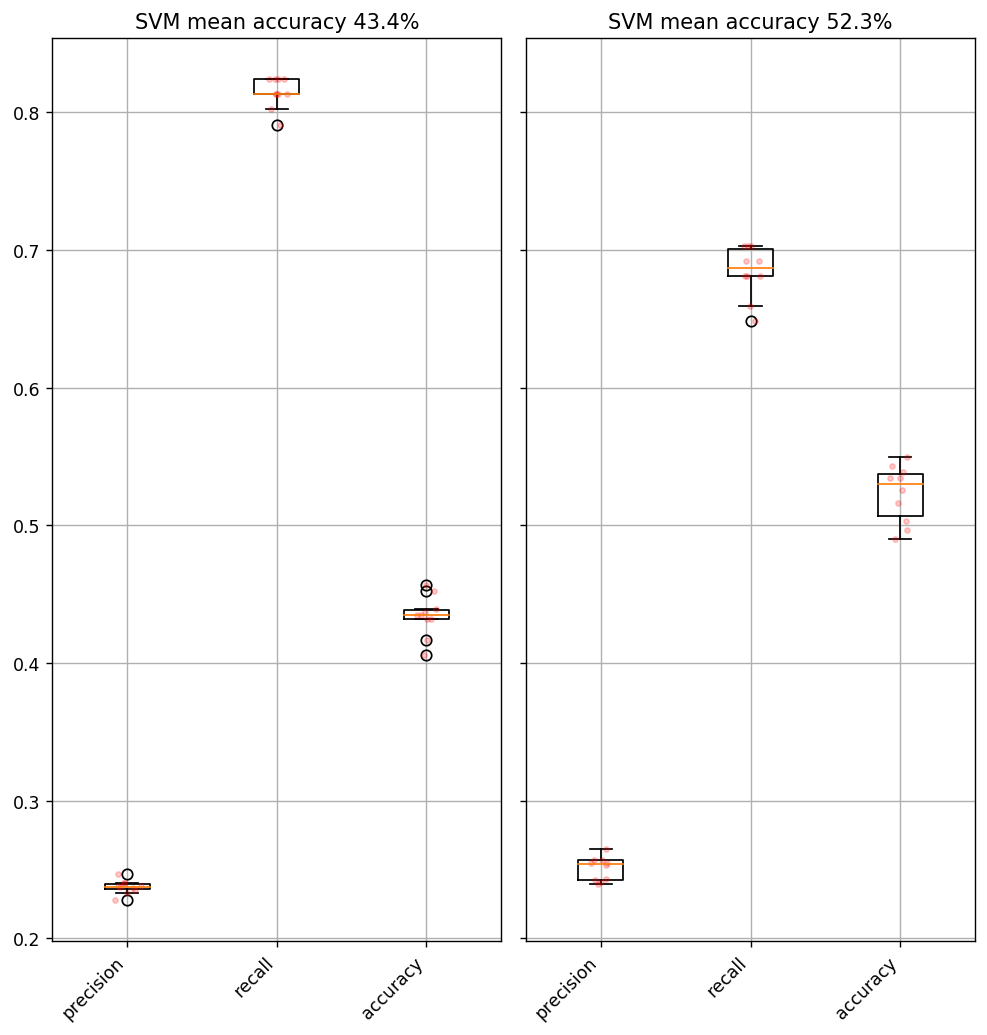

In [23]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

In [20]:
hi_C = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=1000)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10000)
    },
]

hi_C, df = lu.cross_validate_models(X, y, hi_C, seen_index, n_splits=6, df = df)

1
2
3
4
5
6


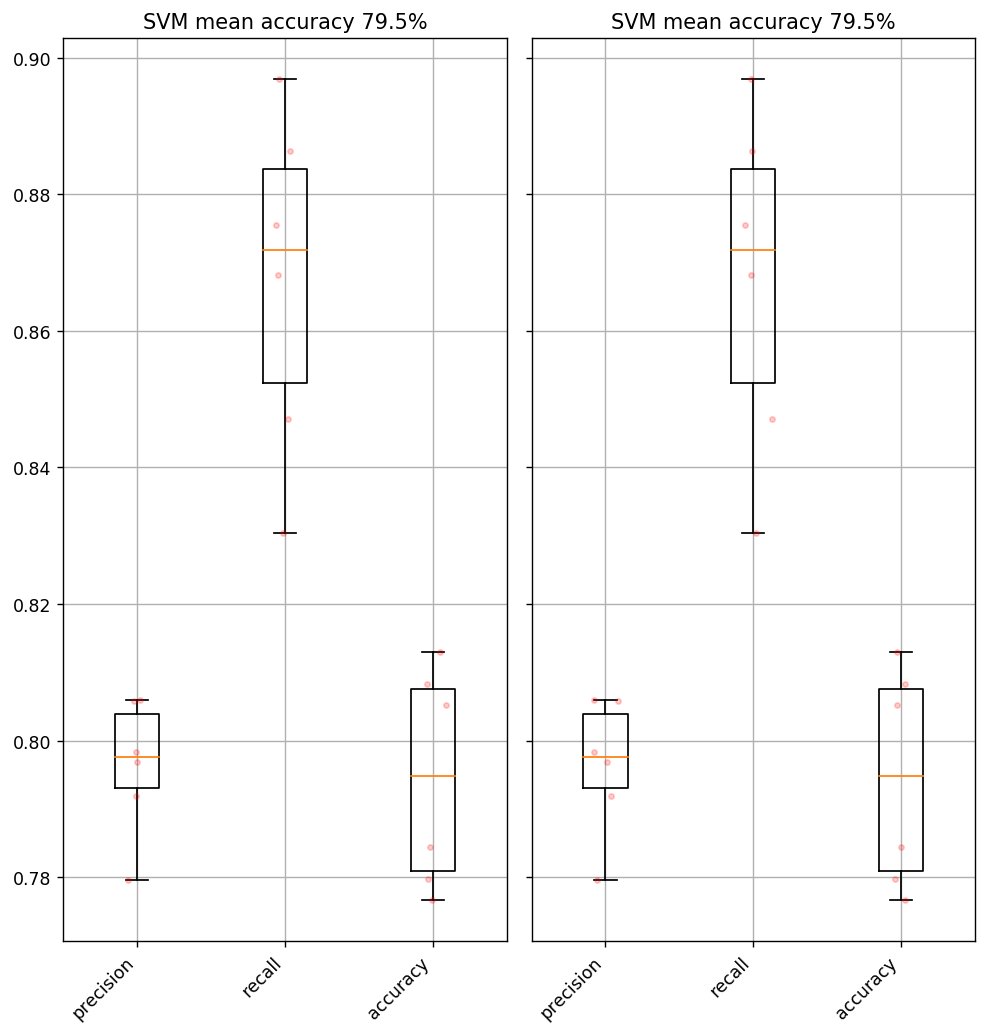

In [21]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(hi_C),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(hi_C,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()